In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from dotenv import load_dotenv

load_dotenv()

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-notebook")

from utils import get_dataset_from_pickle

import plotly.express as px
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))

# City of Los Angeles: Proposing a Strategy for Optimizing Parking Enforcement Deployment
**Author: Evan Gabrielson**

### Overview: 
---
In recent years, the City of Los Angeles has faced a significant financial challenge with its parking enforcement operations. Although traffic fines once provided a steady stream of revenue, a troubling shift occurred starting in 2017. Since then, the costs associated with salaries, equipment, and other expenses for parking enforcement have skyrocketed to over $809 million, while the revenue generated from parking ticket fines has lagged behind at $617 million. This $192 million shortfall highlights the urgent need for more efficient and effective strategies in managing parking violations and enforcement.

### Business Understanding:
---
In his book titled "The High Cost of Free Parking", LA resident and UCLA professor Donald Shoup outlines the necessity of parking enforcement policy to "curb" the excess time and resources a free parking state begets. 
Shoup presents two key recommendations for reform to improve parking policy: pricing curb parking according to fair market value and redistributing parking revenue to neighborhoods for community investment.
Parking enforcement is only necessary to the extent that it improves the maintenance and fair distribution of parking resources such that all actors can benefit equally from public road infrastructure.
Today, however, LA Department of Transportation (LADOT) policy makers are forced to counteract skyhigh salary expenses with parking violation fees well above fair market value while reinvesting nothing back into the communities. 
Until LADOT can produce a net profit from parking enforcement, the citizenry of Los Angeles must continue to expect rising parking violation fees and zero community reinvestment.

In this project, I propose several data-driven strategies for optimizing parking enforcer deployment which LADOT can employ to close the gap between revenue and payroll. 
Here are some facts about LADOT as it functions today:
- LADOT currently deploys an equal distribution of enforcement officers across the City of LA. 
- Enforcers are on duty 24/7
- Parking citations fees range from $53 - $350

In [19]:
citations_df = get_dataset_from_pickle('data/pickle/citations_v0_bronze.pickle')
citations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20529058 entries, 2022-12-13 16:20:58.225000 to 2023-12-27 10:07:08.455000
Data columns (total 5 columns):
 #   Column          Dtype   
---  ------          -----   
 0   fine_amount     float32 
 1   agency          category
 2   violation_code  category
 3   loc_lat         float32 
 4   loc_long        float32 
dtypes: category(2), float32(3)
memory usage: 450.3 MB


### Identifying Outliers in Data
Outlier analysis in exploratory data analysis is crucial because it helps identify data points that deviate significantly from the rest, which may indicate errors, unusual events, or important insights. Understanding these outliers allows for more accurate modeling, better decision-making, and can prevent misleading conclusions.

When working with geospatial data, it is often a good idea to cluster coordinates using algorithmic approaches like KMeans and Agglomerative Clustering or, if available, overlay predefined regions that would be relevant to the model. While geospatial data may be useful for plotting, clusters are better for identifying patterns through machine learning and statistical analysis. A built-in perk of overlaying our geospatial data over the City of LA Parking Enforcement District map is that we automatically filter out data points that lie outside a valid district region. We'll use `geopandas` to facilitate the spatial join operation used to group rows by district.

In [20]:
# Recreate citations DataFrame as GeoDataFrame
citations_gdf = gpd.GeoDataFrame(citations_df, geometry=gpd.points_from_xy(citations_df['loc_long'], citations_df['loc_lat']))

# Build districts GeoDataFrame and set Coordinate Reference System (CRS)
districts_gdf = gpd.read_file("data/geojson/parking_enforcement_districts.geojson")
citations_gdf.set_crs(districts_gdf.crs, inplace=True)

# Compute spatial join (sjoin) operation on 'District' GeoJSON attribute
citations_joined_gdf = gpd.sjoin(citations_gdf, districts_gdf[['geometry', 'District']], how='left', predicate='within')

# Store 'District' label in new 'district' column
citations_df['district'] = citations_joined_gdf['District'].astype('category')
citations_df['district'].value_counts()

district
Hollywood    5025700
Western      4595190
Central      4467880
Valley       3809492
Southern     2556676
Name: count, dtype: int64

We can now view the number of data points lying outside the predefined Parking Enforcement Districts and store a new pickle file with the `loc_lat` and `loc_long` columns then remove them to save memory space for future processing.

In [4]:
# Find centroids for each district
centroids = citations_df.groupby('district')[['loc_lat', 'loc_long']].mean().reset_index()
centroids.head()

,district,loc_lat,loc_long
0,Central,34.057568,-118.240814
1,Hollywood,34.084881,-118.320679
2,Southern,33.962658,-118.289276
3,Valley,34.191124,-118.454765
4,Western,34.029087,-118.424713


In [22]:
# Get geographic outliers
geographic_outliers = citations_df[citations_df['district'].isna()]

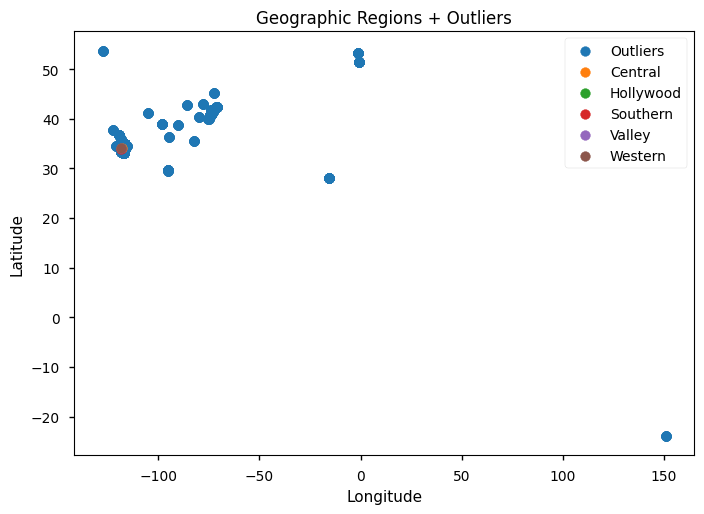

In [12]:
# Plot geographic outliers
plt.figure()
plt.scatter(geographic_outliers['loc_long'], geographic_outliers['loc_lat'], label="Outliers")
for i in centroids.index:
    plt.scatter(centroids.iloc[i,2], centroids.iloc[i,1], label=centroids.iloc[i,0])
plt.title('Geographic Regions + Outliers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [23]:
# Remove geographic outliers
citations_df = citations_df.drop(geographic_outliers.index)
citations_df['district'].isna().sum()

np.int64(0)

In [14]:
# Get violation counts grouped by latitude and longitude
BIN_THRESHOLD = 0.02
to_bin = lambda x: np.floor(x / BIN_THRESHOLD) * BIN_THRESHOLD
citations_df['latbin'] = to_bin(citations_df['loc_lat'])
citations_df['longbin'] = to_bin(citations_df['loc_long'])

geographically_clustered_violations = citations_df.groupby([
    'latbin', 
    'longbin'
]).size().reset_index(name="Count")

citations_df = citations_df.drop(['latbin', 'longbin'], axis=1)

In [ ]:
fig = px.scatter_mapbox(geographically_clustered_violations, lat='latbin', lon='longbin', size="Count", color="Count", color_continuous_scale=px.colors.cyclical.IceFire)
fig.update_layout(height=700, width=512)
fig.show()

**CHECKPOINT REACHED**

We can now separate the `loc_lat` and `loc_long` columns from the DataFrame and save new "Silver"-tier pickle files.

In [25]:
coordinate_df = citations_df[['loc_lat', 'loc_long']]
coordinate_df.to_pickle('data/pickle/citations_v0_coordinates.pickle')

citations_df = citations_df.drop(['loc_lat', 'loc_long'], axis=1)
citations_df.to_pickle('data/pickle/citations_v0_silver.pickle')
citations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20454898 entries, 2022-12-13 16:20:58.225000 to 2023-12-27 10:07:08.455000
Data columns (total 4 columns):
 #   Column          Dtype   
---  ------          -----   
 0   fine_amount     float32 
 1   agency          category
 2   violation_code  category
 3   district        category
dtypes: category(3), float32(1)
memory usage: 312.1 MB


Clean up notebook variables

In [30]:
del citations_df, geographic_outliers, centroids, geographically_clustered_violations, districts_gdf, citations_joined_gdf, citations_gdf, coordinate_df

### Understanding Temporal Citations Trends

In [2]:
from data.eda import plot_citations_per_year, plot_seasonality_decomp, get_timerange, timeseries_decompose

In [3]:
citations_df = pd.read_pickle('data/pickle/citations_v0_silver.pickle')
citations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20454898 entries, 2022-12-13 16:20:58.225000 to 2023-12-27 10:07:08.455000
Data columns (total 4 columns):
 #   Column          Dtype   
---  ------          -----   
 0   fine_amount     float32 
 1   agency          category
 2   violation_code  category
 3   district        category
dtypes: category(3), float32(1)
memory usage: 312.1 MB


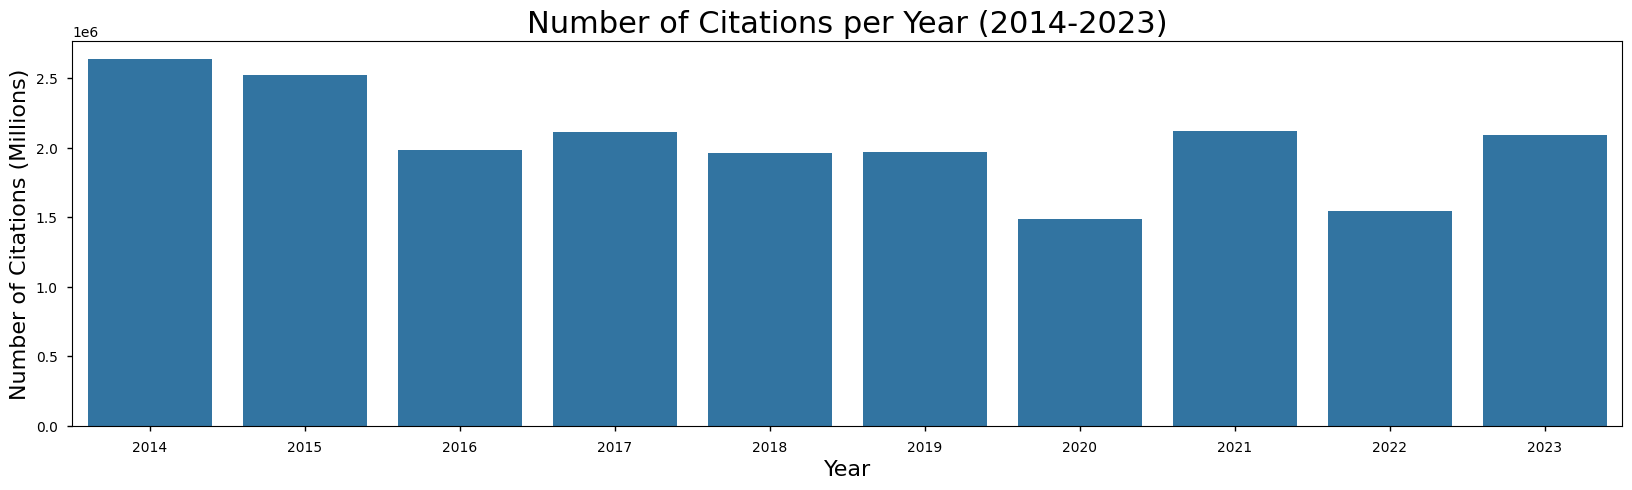

In [4]:
# Plot number of violations per year since 2014
timeseries = get_timerange(citations_df, '2014-1-1').resample('YE').size()
plot_citations_per_year(timeseries)

In [5]:
# Get timeseries and seasonality decomposition from citations
timeseries = get_timerange(citations_df, '2022-12-31', '2024-1-1').resample('d').size()
trend, seasonal, residuals = timeseries_decompose(timeseries)

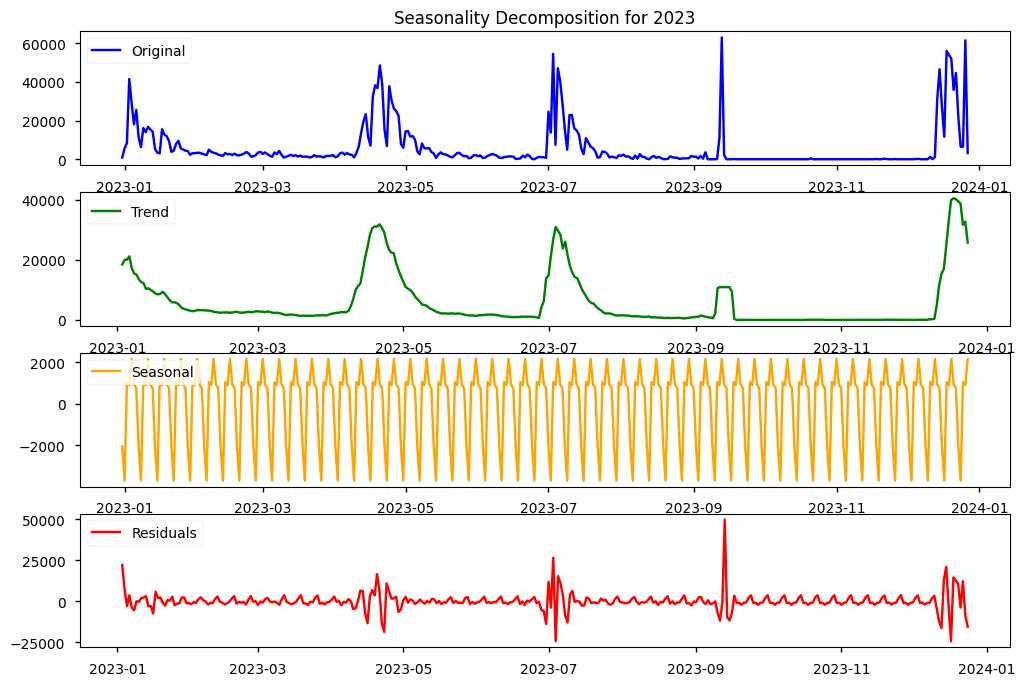

In [6]:
plot_seasonality_decomp(timeseries, trend, seasonal, residuals)

#### Temporal Analysis: Weekly & Hourly Basis
TODO - Add findings

In [7]:
# separate violations into weekdays and weekends
weekdays = citations_df[citations_df.index.weekday<5]
weekends = citations_df[citations_df.index.weekday>=5]

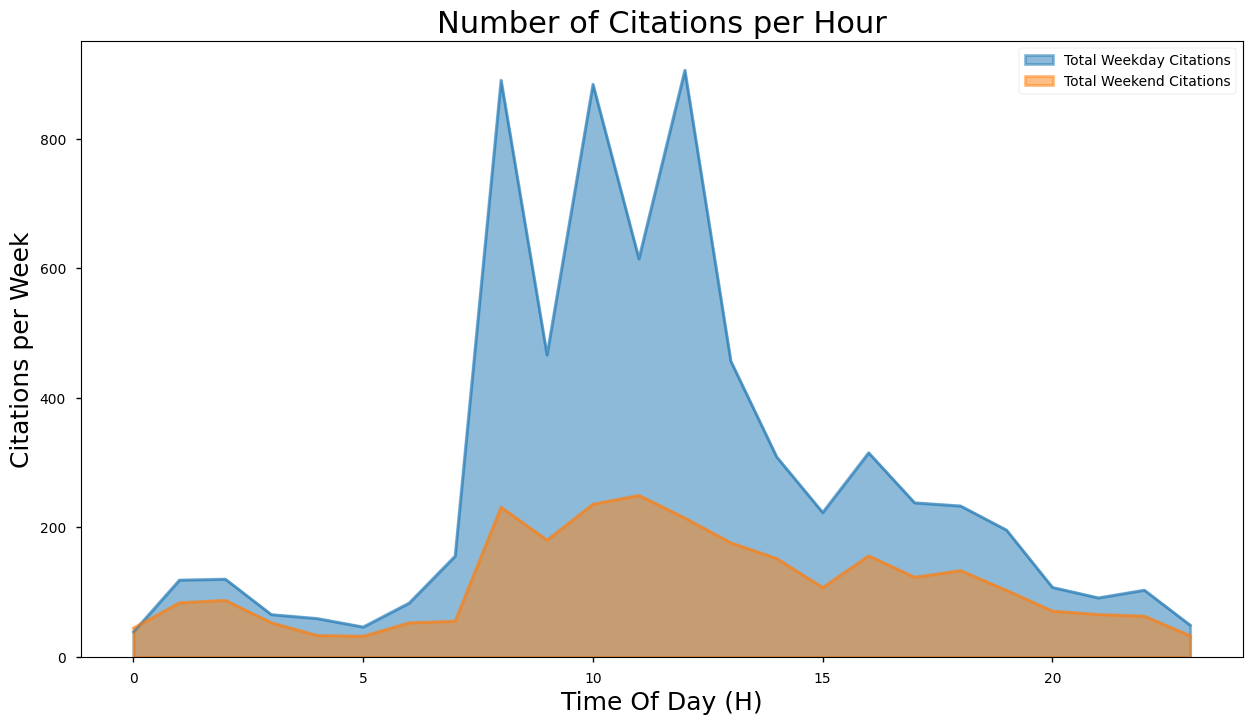

In [8]:
plt.figure(figsize=(15,8))
(weekdays.groupby(weekdays.index.hour).size()/10/52/5).plot(kind='area',label='Total Weekday Citations',linewidth=2,alpha=.5)
(weekends.groupby(weekends.index.hour).size()/10/52/2).plot(kind = 'area',label='Total Weekend Citations',linewidth=2,alpha=.5)
plt.legend()
plt.title('Number of Citations per Hour',fontdict={'fontsize':22})
plt.xlabel('Time Of Day (H)',fontdict={'fontsize':18})
plt.ylabel('Citations per Week',fontdict={'fontsize':18})
plt.savefig('./images/hm_weekday_vs_weekend.png')

#### Temporal Analysis: Daily Basis
TODO - Add findings

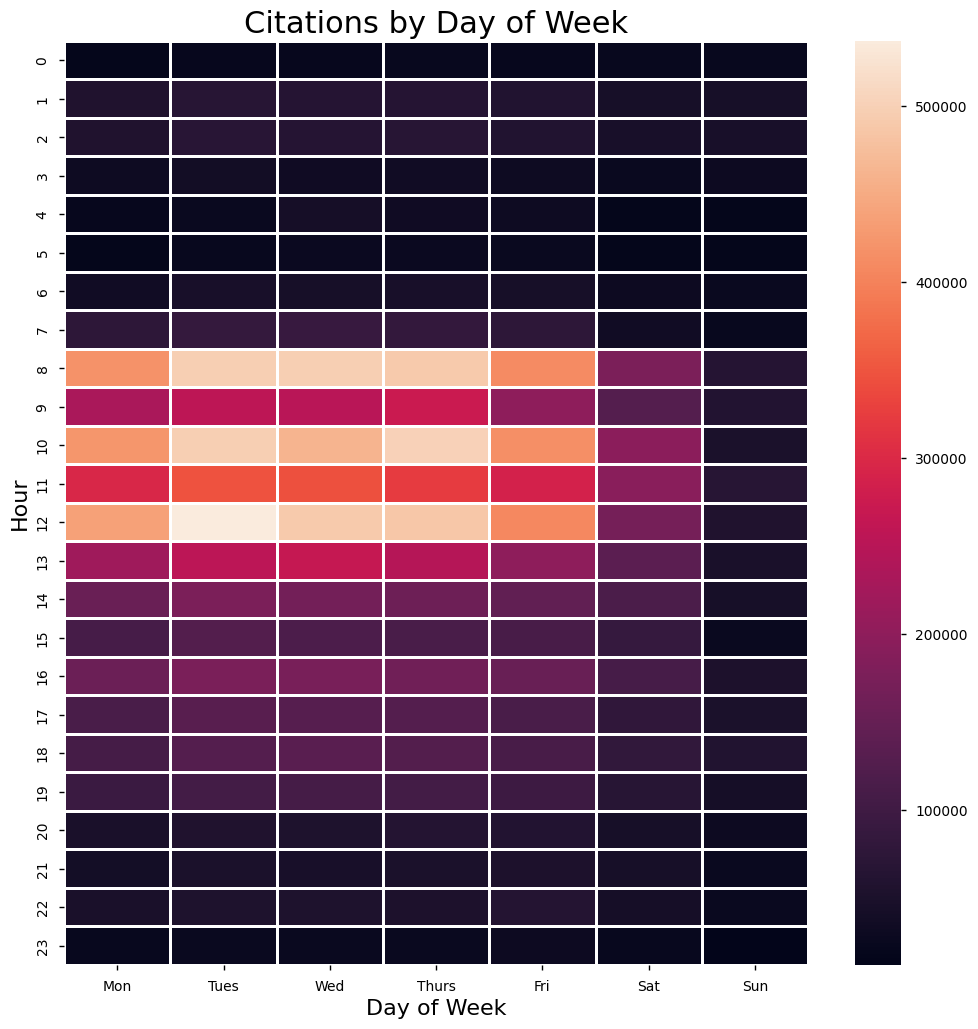

In [9]:
# Weekday analysis
weekdays_by_hour = citations_df.groupby([citations_df.index.hour,citations_df.index.weekday]).size()

plt.figure(figsize=(12,12))
sns.heatmap(weekdays_by_hour.unstack(), xticklabels = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'], linewidths=1)
plt.title('Citations by Day of Week',fontdict={'fontsize':22})
plt.ylabel('Hour',fontdict={'fontsize':16})
plt.xlabel('Day of Week',fontdict={'fontsize':16})
plt.savefig('./images/hm_daily.png')

TODO - Based on traffic density

#### Categorical Analysis: Violation Codes
TODO - Add findings

| Code | Description |
| ---- | ----------- |
| 80.69BS | PARKING PROHIBITED |
| 88.13B+ | FAILURE TO PAY FOR A PARKING METER SPACE |
| 80.56E4 | PARKED IN NO STOPPING CURB ZONE |
| 80.58L | PARKED IN PREFERENTIAL PARKING DISTRICT WITHOUT PERMIT |
| 5204A- | REGISTRATION TAB IMPROPERLY ATTACHED TO LICENSE |
| 80.69B | PARKING PROHIBITED |
| 5200 | LICENSE PLATE DISPLAY ISSUE |
| 80.69C | TIME LIMIT EXCEEDED |
| 80.69AP+ | CAR WITH TRAILER PARKING PROHIBITED | 
| 80.56 | PARKED IN PASSENGER LOADING ZONE |
| 80.61 | PARKED IN ALLEY |
| 22500E | BLOCKING DRIVEWAY |
| 80.70 | PARKED IN ANTI-GRIDLOCK ZONE |
| 80.69AA+ | PARKING PROHIBITED | 

In [10]:
INCLUDE_THRESHOLD = citations_df.shape[0]*1//100
print(f"A given violation code must exceed a count of {INCLUDE_THRESHOLD} to be included in this analysis.")
violation_code_counts = citations_df['violation_code'].value_counts()
filtered_codes = violation_code_counts[violation_code_counts > INCLUDE_THRESHOLD].index
violation_code_counts = citations_df[citations_df['violation_code'].isin(filtered_codes)]

A given violation code must exceed a count of 204548 to be included in this analysis.


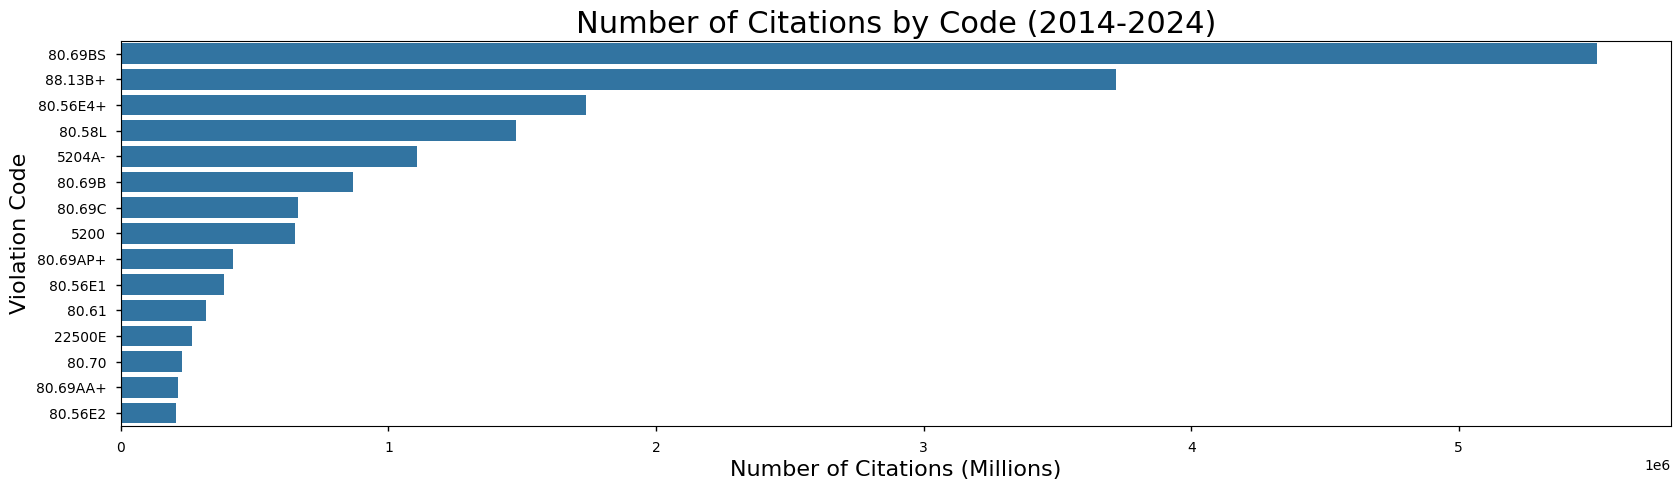

In [11]:
plt.figure(figsize=(20, 5))
sns.countplot(data=violation_code_counts, y='violation_code', order=filtered_codes)
plt.title('Number of Citations by Code (2014-2024)', fontdict={'fontsize':22})
plt.ylabel("Violation Code", fontdict={'fontsize':16})
plt.xlabel("Number of Citations (Millions)",fontdict={'fontsize':16})
plt.savefig('./images/citations_by_code.png')